This notebook assumes you are using sims_maf version >= 2.2, and have 'setup sims_maf' in your shell. 

This notebook demonstrates the basic use of stackers. You can also look at the "Dithers" notebook for more examples, specifically pertaining to dithering. 

Stackers allow the creation of 'virtual' columns to extend the opsim database. These columns are created on-the-fly, using the algorithms in the Stackers classes and cease to exist after the data queried by MAF leaves memory. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

MAF provides a set of stock Stackers, and more are available with the sims_maf_contrib package. You can see the list of registered stackers like this:

In [2]:
stackers.BaseStacker.help(doc=False)

EclipticStacker
FilterColorStacker
GalacticStacker
HexDitherFieldPerNightStacker
HexDitherFieldPerVisitStacker
HexDitherPerNightStacker
HourAngleStacker
M5OptimalStacker
NEODistStacker
NormAirmassStacker
ParallacticAngleStacker
ParallaxFactorStacker
RandomDitherFieldPerNightStacker
RandomDitherFieldPerVisitStacker
RandomDitherPerNightStacker
SdssRADecStacker
SeasonStacker
SpiralDitherFieldPerNightStacker
SpiralDitherFieldPerVisitStacker
SpiralDitherPerNightStacker
ZenithDistStacker


---
Let's look at how you might use a simple stacker to calculate the mean of the Hour Angle visited each night. By default Opsim does not provide the Hour Angle, but you can see above that we provide a stacker (HourAngleStacker) to calculate it automatically if requested. 

To use simple stackers that do not require configuration (such as the HourAngleStacker), simply reference the column name which the stacker adds to the opsim data ('simdata').

In [3]:
metric = metrics.MeanMetric(col='HA')
slicer = slicers.OneDSlicer(sliceColName='night', binsize=1)
sqlconstraint = 'night<100'
runName = 'enigma_1189'
mB = metricBundles.MetricBundle(metric, slicer, sqlconstraint, runName=runName)

In [4]:
opsdb = db.OpsimDatabase(runName+'_sqlite.db')
outDir = 'stackers_test'
resultsDb = db.ResultsDb(outDir=outDir)

We have not set up or referenced the stacker, except by the column name, but when we get the data from the database (done during the 'runAll' step), we can see that the stacker has been called and the virtual column added to the simdata results.

In [5]:
bgroup = metricBundles.MetricBundleGroup({'ha':mB}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
print bgroup.simData.dtype.names

Querying database with constraint night<100
Found 76940 visits
Running:  ['ha']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
('obsHistID', 'lst', 'fieldRA', 'night', 'HA')


Plotting figures with night<100 sqlconstraint now.
Plotting complete.


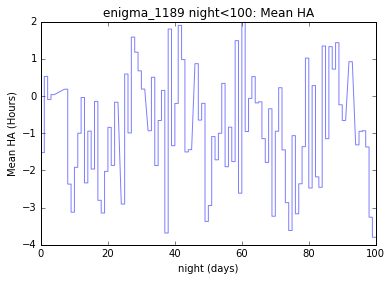

In [6]:
bgroup.plotAll(closefigs=False)

Now let's use a stacker to try out some different dithering options.  Rather than the standard fieldRA and fieldDec columns, we'll add columns that are slightly offset.

In [7]:
slicer = slicers.HealpixSlicer(nside=64, lonCol='randomDitherFieldPerNightRa', latCol='randomDitherFieldPerNightDec')
sqlconstraint = 'filter="r" and night<400'

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [8]:
metric = metrics.CountMetric(col='night')

We could use the stacker in its default configuration, but we want to change it so that the maxDither is much smaller. To do this, we must instantiate the stacker and configure it ourselves, then pass this to the metricBundle.

In [9]:
maxDither = 0.1
stackerList = [stackers.RandomDitherFieldPerNightStacker(maxDither=maxDither)]

In [19]:
plotDict={'colorMax':50, 'xlabel':'Number of Visits', 
          'label':'max dither = %.2f' % maxDither, 'cmap':'viridis'}
bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, runName=runName, 
                                    stackerList=stackerList, plotDict=plotDict)
bgroup = metricBundles.MetricBundleGroup({'dither':bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)

In [20]:
bgroup.runAll()

Querying database with constraint filter="r" and night<400
Found 46128 visits
Running:  ['dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter="r" and night<400 sqlconstraint now.
monopole: 14.2371  dipole: lon: 57.6414, lat: -76.7238, amp: 7.68662
Plotting complete.


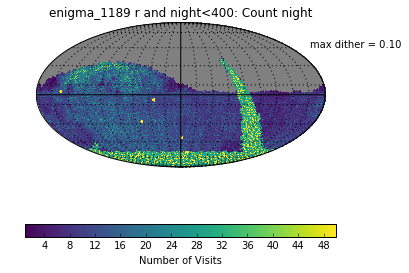

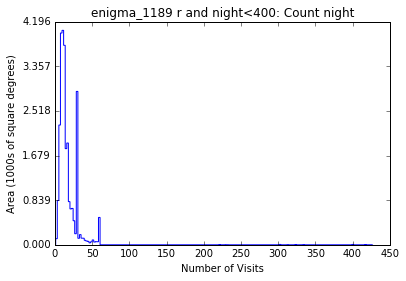

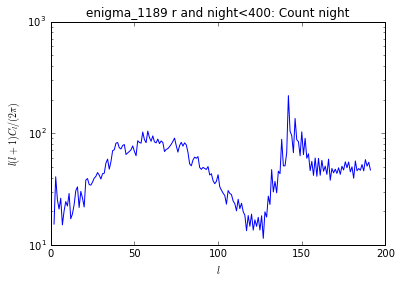

In [21]:
bgroup.plotAll(closefigs=False)

In [23]:
# Update the stacker to use a larger max dither and re-run the bundle
maxDither = 1.75
plotDict2 = {'colorMax': 50, 'xlabel': 'Number of Visits', 
             'label': 'max dither = %.2f' % maxDither, 'cmap': 'viridis'}
stackerList = [stackers.RandomDitherFieldPerNightStacker(maxDither=maxDither)]
bundle2 = metricBundles.MetricBundle(metric, slicer, sqlconstraint, stackerList=stackerList, plotDict=plotDict2)
bgroup2 = metricBundles.MetricBundleGroup({'dither_large':bundle2}, opsdb, outDir=outDir, resultsDb=resultsDb)

In [24]:
bgroup2.runAll()

Querying database with constraint filter="r" and night<400
Found 46128 visits
Running:  ['dither_large']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter="r" and night<400 sqlconstraint now.


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 826 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 13.8013  dipole: lon: 61.172, lat: -76.4121, amp: 8.38346
Plotting complete.


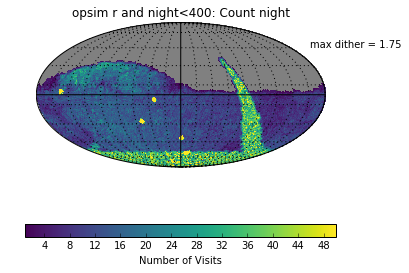

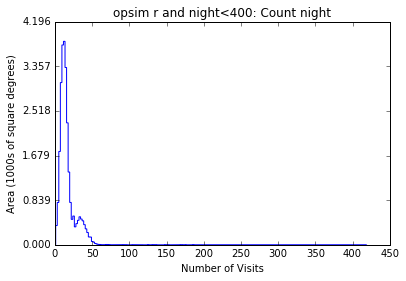

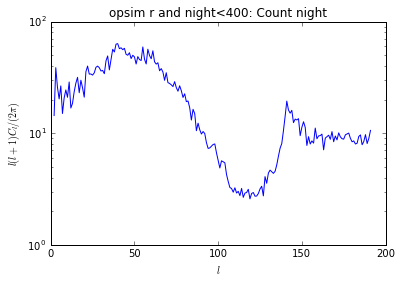

In [25]:
bgroup2.plotAll(closefigs=False)

Now we can combine the results on a single plot if we want to more easily compare them.

monopole: 14.2371  dipole: lon: 57.6414, lat: -76.7238, amp: 7.68662
monopole: 13.8013  dipole: lon: 61.172, lat: -76.4121, amp: 8.38346


1

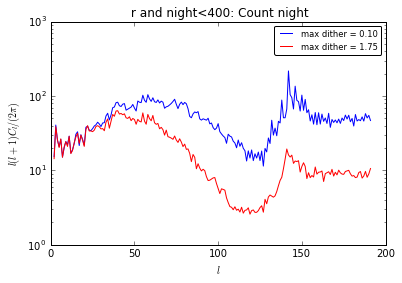

In [26]:
ph = plots.PlotHandler()
ph.setMetricBundles([bundle, bundle2])
ph.setPlotDicts([{'label':'max dither 0.1', 'color':'b'}, {'label':'max dither 1.75', 'color':'r'}])
ph.plot(plots.HealpixPowerSpectrum())